In [1]:
import pandas as pd
import numpy as np

from data_splitter import get_modelling_data
from scipy.stats import randint, uniform

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data_inn2 = get_modelling_data('../input/inning_2.csv', inning=2)
X_train = data_inn2['X_train']
# X_val = data_inn2['X_val']
X_test = data_inn2['X_test']
y_train = data_inn2['y_train']
# y_val = data_inn2['y_val']
y_test = data_inn2['y_test']
min_scaler = data_inn2['min_scaler']
std_scaler = data_inn2['std_scaler']
encoder = data_inn2['encoder']

(93250, 22)


In [3]:
numerical_cols = std_scaler.transform(X_train.select_dtypes(exclude='object'))
categorical_cols = encoder.transform(X_train.select_dtypes(include='object'))

X_train_scaled = np.hstack((numerical_cols,categorical_cols))

In [4]:
numerical_cols_ = std_scaler.transform(X_test.select_dtypes(exclude='object'))
categorical_cols_ = encoder.transform(X_test.select_dtypes(include='object'))

X_test_scaled = np.hstack((numerical_cols_,categorical_cols_))

In [5]:
X_train.shape[0] + X_test.shape[0]

93250

In [15]:
numerical_cols__ = std_scaler.transform(X_val.select_dtypes(exclude='object'))
categorical_cols__ = encoder.transform(X_val.select_dtypes(include='object'))

X_val_scaled = np.hstack((numerical_cols__,categorical_cols__))

In [6]:
def accuracy_func(x,y,over,model):
        x_ = x[x["current_over"]>=over]
        y_ = y[x["current_over"]>=over]
        
        numerical_cols = std_scaler.transform(x_.select_dtypes(exclude='object'))
        categorical_cols = encoder.transform(x_.select_dtypes(include='object'))

        x_ = np.hstack((numerical_cols,categorical_cols))
        return model.score(x_,y_)
        

In [7]:
def plot_scores(model,name):
    accuracy_list_train = []
    accuracy_list_test = []
    for i in range(20):

        accuracy_list_train.append(accuracy_func(X_train,y_train,i,model))
        accuracy_list_test.append(accuracy_func(X_test,y_test,i,model))

    import matplotlib.pyplot as plt
    plt.plot(range(1,21),accuracy_list_train)
    plt.plot(range(1,21),accuracy_list_test)
    plt.title(name)
    plt.xlabel('Over')
    plt.ylabel('Accuracy_score')
    plt.xticks(range(1,21))
    plt.grid()
    return plt.show()    

## Logistic Regression

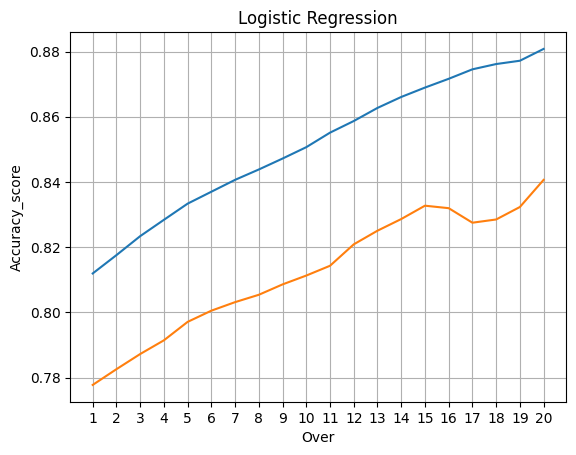

Training Accuracy: 0.8119212301360467
Test Accuracy: 0.7777348113775028
F1Score: 0.7926237722990579


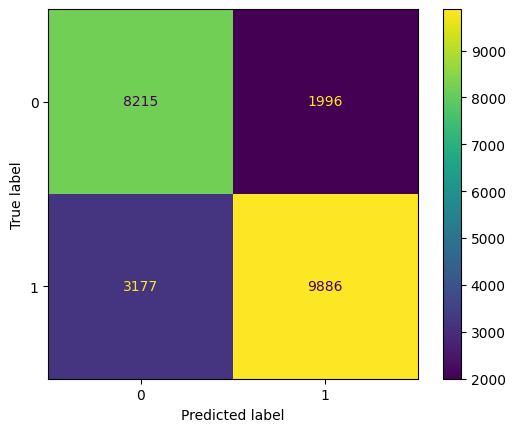

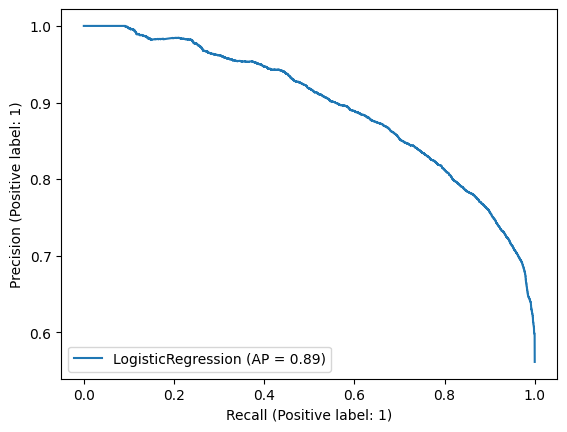

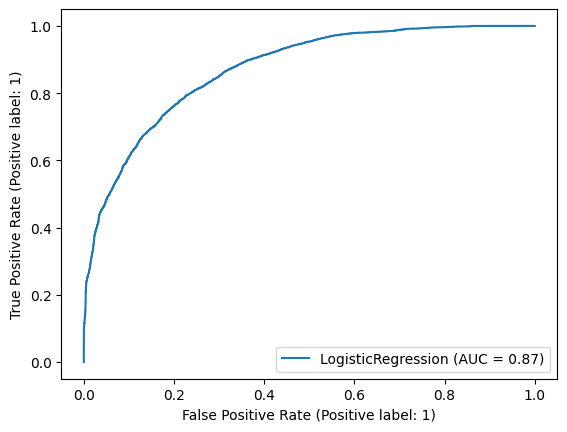

In [20]:
# lr = LogisticRegression(penalty='l2',C = 0.04, solver='liblinear', class_weight={0:0.6,1:0.5})
lr = LogisticRegression(penalty='l2',C = 0.04, solver='liblinear', class_weight={0:0.6,1:0.5})
lr.fit(X_train_scaled,y_train)
plot_scores(lr,'Logistic Regression')
print('Training Accuracy:',metrics.accuracy_score(y_train,lr.predict(X_train_scaled)))
print('Test Accuracy:', metrics.accuracy_score(y_test,lr.predict(X_test_scaled)))
metrics.plot_confusion_matrix(lr,X_test_scaled,y_test)
metrics.plot_precision_recall_curve(lr,X_test_scaled,y_test)
metrics.plot_roc_curve(lr, X_test_scaled,y_test)
print('F1Score:', metrics.f1_score(y_test,lr.predict(X_test_scaled)))

## Decision Tree Classifier

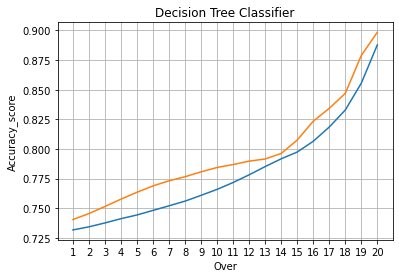

Training Accuracy: 0.7315807579840605
Test Accuracy: 0.7403559567401856
F1Score: 0.7297225423278079


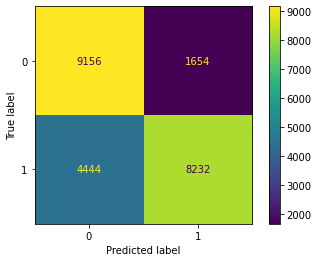

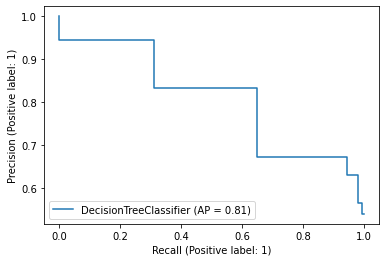

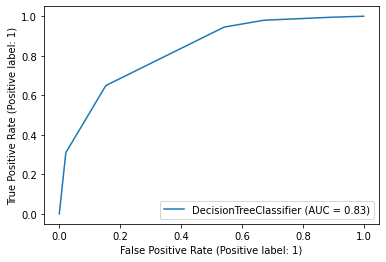

In [70]:
from sklearn.tree import DecisionTreeClassifier

#Hyper Parameter Tuning
param_dist = {  "splitter":['best','random'],
                "criterion":['gini','entropy'],
                "max_features":uniform(0.1,1.0),
                "max_depth":range(1,7),
                "max_leaf_nodes":range(1,7)
            }
clf = RandomizedSearchCV(DecisionTreeClassifier(),
                        param_distributions= param_dist,n_iter=50, cv=5)
clf.fit(X_train_scaled,y_train)
dtc = clf.best_estimator_

dtc.fit(X_train_scaled,y_train)
# dtc = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3, max_features=0.3,class_weight={0:0.6,1:0.5}).fit(X_train_scaled,y_train)
plot_scores(dtc,'Decision Tree Classifier')
print('Training Accuracy:',accuracy_score(y_train,dtc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,dtc.predict(X_test_scaled)))
plot_confusion_matrix(dtc,X_test_scaled,y_test)
plot_precision_recall_curve(dtc,X_test_scaled,y_test)
plot_roc_curve(dtc, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,dtc.predict(X_test_scaled)))

## Random Forest Classifier

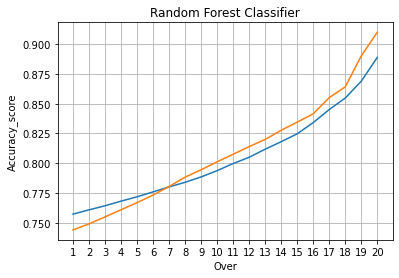

Training Accuracy: 0.7572100223611031
Test Accuracy: 0.743975134122456
F1Score: 0.7687396638590823


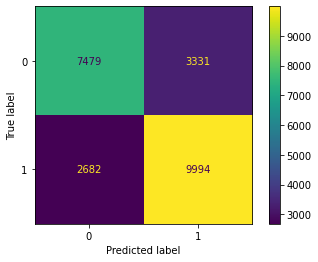

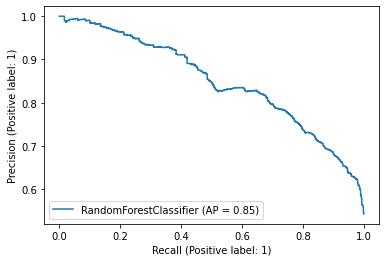

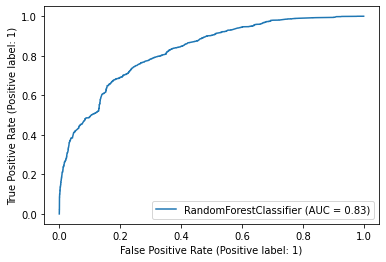

In [53]:
rfc = RandomForestClassifier(n_estimators= 100,
                             max_depth=2, 
                             max_leaf_nodes=3, 
                             max_features=0.3).fit(X_train_scaled,y_train)
plot_scores(rfc,'Random Forest Classifier')
print('Training Accuracy:',accuracy_score(y_train,rfc.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,rfc.predict(X_test_scaled)))
plot_confusion_matrix(rfc,X_test_scaled,y_test)
plot_precision_recall_curve(rfc,X_test_scaled,y_test)
plot_roc_curve(rfc, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,rfc.predict(X_test_scaled)))

## Gradient Boosting Classifier

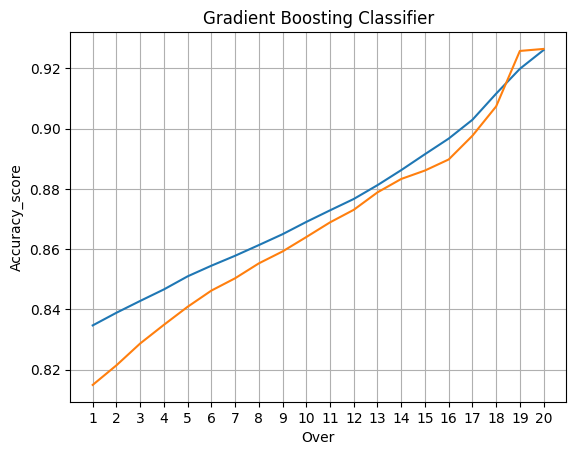

Training Accuracy: 0.8346575968903625
Test Accuracy: 0.8149007476153648
F1Score: 0.8298846943610804


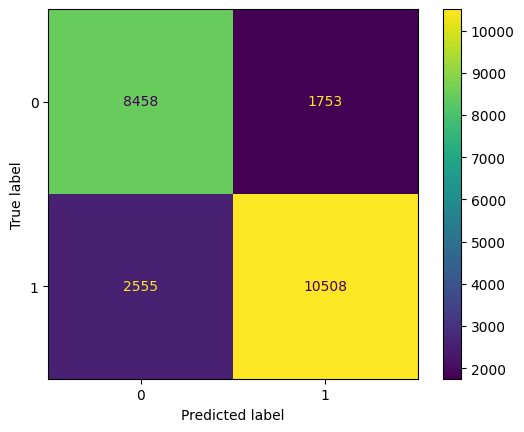

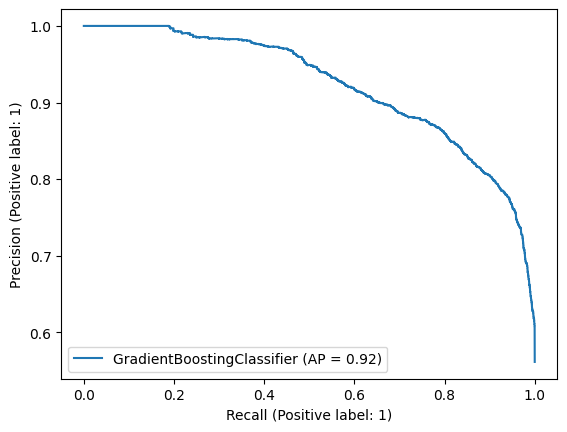

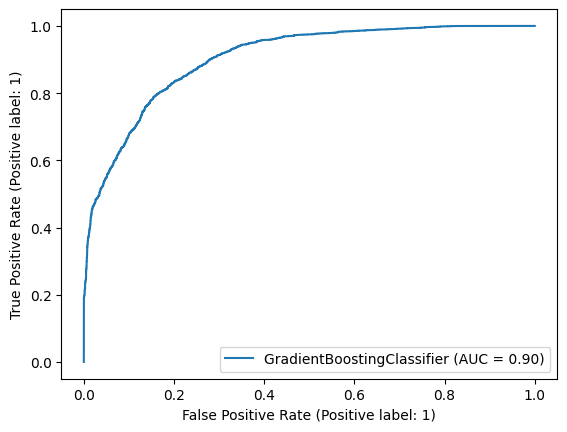

In [21]:
gbdt = ensemble.GradientBoostingClassifier(max_depth=2,
                           max_features=0.7, min_samples_leaf=2,
                           n_estimators=150)


gbdt.fit(X_train_scaled,y_train)

plot_scores(gbdt,'Gradient Boosting Classifier')
print('Training Accuracy:',metrics.accuracy_score(y_train, gbdt.predict(X_train_scaled)))
print('Test Accuracy:', metrics.accuracy_score(y_test, gbdt.predict(X_test_scaled)))
metrics.plot_confusion_matrix(gbdt, X_test_scaled,y_test)
metrics.plot_precision_recall_curve(gbdt, X_test_scaled, y_test)
metrics.plot_roc_curve(gbdt, X_test_scaled, y_test)
print('F1Score:', metrics.f1_score(y_test, gbdt.predict(X_test_scaled)))

In [22]:
gbdt.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.74471738e-03,
       5.34972464e-02, 1.93827237e-02, 6.21484176e-03, 0.00000000e+00,
       3.17047371e-02, 0.00000000e+00, 4.45097778e-02, 1.11945852e-02,
       2.81618471e-02, 6.66709017e-03, 5.37562833e-02, 5.67734567e-01,
       0.00000000e+00, 9.29006746e-05, 0.00000000e+00, 1.03719188e-02,
       1.11793907e-03, 9.25746252e-04, 2.32215928e-03, 1.25847288e-03,
       5.32743985e-03, 1.94111302e-03, 0.00000000e+00, 6.73642657e-03,
       1.37291297e-02, 0.00000000e+00, 1.02957129e-02, 3.54781681e-03,
       2.92464227e-03, 0.00000000e+00, 0.00000000e+00, 4.90769119e-03,
       2.84192326e-02, 0.00000000e+00, 1.04126184e-02, 8.46400583e-04,
       3.49124954e-03, 7.03619165e-05, 7.02980788e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.83982790e-03, 1.06452935e-03, 0.00000000e+00,
       2.19060680e-04, 0.00000000e+00, 8.20694798e-03, 1.53399214e-03,
      

In [94]:
models_data = pd.DataFrame(columns=["Model Name","Train Accuracy","Test Accuracy","Log Loss","Precision","Recall","F1 Score"])
models_data

,Model Name,Train Accuracy,Test Accuracy,Log Loss,Precision,Recall,F1 Score


In [95]:
def update_models_data(model,model_name):
    global models_data
   
    model.fit(X_train_scaled,y_train)
    out = model.predict(X_test_scaled)
    out_proba = model.predict_proba(X_test_scaled)
    trn_acc = accuracy_score(y_train,model.predict(X_train_scaled))
    tst_acc = accuracy_score(y_test,out)
    l_loss = log_loss(y_test,out_proba)
    prec = precision_score(y_test,out)
    rec = recall_score(y_test,out)
    f1 = f1_score(y_test,out)
    
    models_data = models_data.append({"Model Name": model_name,
                        "Train Accuracy":trn_acc,
                        "Test Accuracy":tst_acc,
                        "Log Loss":l_loss,
                        "Precision":prec,
                        "Recall":rec,
                        "F1 Score":f1,
                        },
                       ignore_index = True)

In [96]:
update_models_data(lr,'Logistic Regression')
update_models_data(dtc,'Decision Tree')
update_models_data(rfc,'Random Forest')
update_models_data(gbdt,'Gradient Boosting')

In [97]:
models_data

,Model Name,Train Accuracy,Test Accuracy,Log Loss,Precision,Recall,F1 Score
0,Logistic Regression,0.810074,0.792898,0.423406,0.819118,0.790944,0.804784
1,Decision Tree,0.724442,0.696841,0.507729,0.746451,0.663774,0.702689
2,Random Forest,0.754702,0.748063,0.563155,0.768321,0.763411,0.765858
3,Gradient Boosting,0.821943,0.779486,0.427615,0.790514,0.80467,0.797529


## Saving Model

In [ ]:
import pickle
with open("saved_pickle/model_inn2.pkl", 'wb') as f:
    pickle.dump(lr,f)

In [ ]:
with open("saved_pickle/model_inning2.pkl", 'wb') as f:
    pickle.dump(gbdt,f)

In [ ]:
with open("saved_pickle/model_inning2.pkl", 'rb') as f:
    gbdt= pickle.load(f)

# *Hyperparameter Tuning for LogisticRegression*

In [33]:
param_dist = {
             "C":uniform(0.1,1),
             "class_weight":{0:uniform(0,1), 1:uniform(0,1)}
             }
clf = RandomizedSearchCV(LogisticRegression(),
                        param_distributions= param_dist, n_iter=10, cv=5)
clf.fit(X_train,y_train)
lr = clf.best_estimator_
lr

# *Hyperparameter Tuning for RandomForest*

In [13]:
param_dist = {"n_estimators": list(range(10,100,10)),
               "max_features":range(5,20,2),
               "max_samples":uniform(0.1,0.8),
              "max_depth":range(3,15),
              "min_samples_leaf": range(1,4)
             }
clf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions= param_dist, n_iter=20, cv=5)
clf.fit(X_train_scaled,y_train)
lr = clf.best_estimator_
lr

RandomForestClassifier(max_depth=10, max_features=19,
                       max_samples=0.5668338542998387, min_samples_leaf=3,
                       n_estimators=50)

In [123]:
param_dist = {
              "n_estimators": list(range(20,70,10)),
              "max_features":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
              "max_depth":range(1,5),
              "min_samples_leaf": range(1,5),
             }
clf = RandomizedSearchCV(GradientBoostingClassifier(),
                        param_distributions= param_dist, n_iter=30, cv=3)
clf.fit(X_train_scaled,y_train)
lr = clf.best_estimator_
lr

GradientBoostingClassifier(max_features=0.1, min_samples_leaf=3,
                           n_estimators=50)

In [51]:
lr = clf.fit(X_train,y_train)

In [52]:
lr = clf.best_estimator_

In [171]:
lr = GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                           max_features=13, min_samples_leaf=3,
                           n_estimators=30)

In [172]:
lr.fit(X_train_scaled,y_train)

GradientBoostingClassifier(learning_rate=0.07, max_depth=5, max_features=13,
                           min_samples_leaf=3, n_estimators=30)